# Kubeflow Multinode Example Pipeline with MPIJobs

## Summary

1. Validate the Kubernetes/Kubeflow environment is setup properly for Multi-GPU and Multinode GPU jobs.
2. Configure this Jupyter environment with the tools needed to interact with Kubeflow and Kubernetes.
3. Define and deploy a Kubeflow pipeline to create K8S PersistentVolumes and download/processess an NLP dataset.
4. Define ande deploy a Kubeflow pipeline to create a multi-pod MPIJob to train TransformerXL using the pre-processed data.
5. Poll the MPIJobs for status, inspect the Worker logs, and cleanup all resources.

The example being used mirrors the Getting Started Guide found on [NGC](https://ngc.nvidia.com/catalog/resources/nvidia:transformerxl_for_tensorflow/quickStartGuide).

## Pre-requisites

Before running through this notebook it is assumed that you have installed Kubernetes, Kubeflow, and the MPI Operator.

For initial setup steps see:

1. [Kubernetes Deployment with DeepOps](https://github.com/NVIDIA/deepops/blob/master/docs/kubernetes-cluster.md)
2. [Kubeflow Deployment with DeepOps](https://github.com/NVIDIA/deepops/blob/master/docs/kubeflow.md) (this may include installation of the MPI Operator)
3. [MPI Operator Installation](https://github.com/kubeflow/mpi-operator)

For production multinode workloads it is also recommended to have properly configured networking using RDMA or RoCE, see [here](https://github.com/NVIDIA/deepops/blob/master/docs/roce-perf-k8s.md) for more details.

### Running this notebook

This notebook can be run on any Kubeflow-compatible Jupyter Container (including the default Kubeflow containers) or can be launched on the same node where your Kubernetes cluster is running.

For best results, launch one of the default containers through the Kubeflow Notebook interface.

![kubeflow-notebook.png](kubeflow-notebook.png)

### Installing notebook dependencies
Before we can interact with Kubeflow or Kubernetes from a Jupyter notebook we need to install a few dependencies. This includes the Kubeflow and Kubernetes Python libraries as well as the `kubectl` binary.

In [1]:
# kfp is the kubeflow pipeline sdk, we use this to compile pipelines and execute them
!pip install kfp

You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
# kubernetes is the library that allows us to initialize a Python k8s_client
!pip install kubernetes

You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
# Download kubectl so we can tail mpijob logs
!curl -LO https://storage.googleapis.com/kubernetes-release/release/`curl -s https://storage.googleapis.com/kubernetes-release/release/stable.txt`/bin/linux/amd64/kubectl 
!chmod +x kubectl

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 41.9M  100 41.9M    0     0  75.8M      0 --:--:-- --:--:-- --:--:-- 75.6M


### Generate the Kubeflow pipeline
Once we have our Kubernetes environment properly setup and our notebook is configured with the proper libraries we can create a pipeline.

We first define an `@kfp.dsl.pipeline` function that contains each pipeline opration and we then `compile` the pipeline to a file.

After we do that we can create a `Client` to the local Kubeflow installation and submit the generated pipeline to run.

In [4]:
# Import some general libraries to be used later in the notebook
from kubernetes import client as k8s_client
import json
import time

In [5]:
'''This is the Kubeflow pipeline that initializes the dataset before we begin training the model.

It is an implementation of https://ngc.nvidia.com/catalog/resources/nvidia:transformerxl_for_tensorflow/quickStartGuide

1. Create a K8S PersistentVolume to store "data" and "code"
2. Download "code" to the "code" volume
3. Run a shell script to download data to the "data" volume
4. Convert the data to tfrecord format
'''

import yaml
import uuid
import kfp
import kfp.dsl as dsl


@dsl.pipeline(
    name="Multinode Data POC",
    description="A quick hello-world MPIJob resource using the NGC TransformerXL example"
)
def resourceop_multinode():
    # Use the Tensorflow Docker Image from NGC https://ngc.nvidia.com/catalog/containers/nvidia:tensorflow   
    __IMAGE_VERSION__ = 'nvcr.io/nvidia/tensorflow:20.06-tf1-py3'

    # Download the NVIDIA DeepLearningExamples Git repo into a PersistentVolume
    code_volume_op = dsl.VolumeOp(
        name="code_volume_creation",
        resource_name="transformer_xl_code",
        size="5Gi"
    )
    code_download_op = dsl.ContainerOp(
        name="code_download",
        image=__IMAGE_VERSION__,
        command=["/bin/bash", "-cx"],
        arguments=["cd /mnt; git clone https://github.com/NVIDIA/DeepLearningExamples"],
        pvolumes={"/mnt": code_volume_op.volume}
    )

    # After downloading the repo, use the TransformerXL data download script to download data to a new PersistentVolume
    data_volume_op = dsl.VolumeOp(
        name="data_volume_creation",
        resource_name="transformer_xl_data",
        size="20Gi"
    )
    data_download_op = dsl.ContainerOp(
        name="data_download",
        image=__IMAGE_VERSION__,
        command=["/bin/bash", "-cx"],
        arguments=["cd /; /mnt/DeepLearningExamples/TensorFlow/LanguageModeling/Transformer-XL/getdata.sh"],
        pvolumes={"/data": data_volume_op.volume,
                  "/mnt": code_download_op.pvolume}
    )
    
    # After downloading the data, convert to tfrecords
    data_convert_op = dsl.ContainerOp(
        name="create_tfrecord",
        image=__IMAGE_VERSION__,
        command=["/bin/bash", "-cx"],
        arguments=["/usr/bin/python /mnt/DeepLearningExamples/TensorFlow/LanguageModeling/Transformer-XL/tf/data_utils.py \
                     --data_dir=/data/wikitext-103// --dataset=wt103 --tgt_len=64 --num_passes=2 \
                    --use_tpu=False --eval_batch_size=0 --batch_chunk 16"],
        pvolumes={"/mnt": code_volume_op.volume,
                  "/data": data_volume_op.volume}    
    ).after(data_download_op)

In [6]:
# Compile the pipeline to a local file
kfp.compiler.Compiler().compile(resourceop_multinode, 'multinode-data-example.yaml')

### Running the pipeline
After we have compiled the pipeline to a `yaml` file, the next step is to create a kubeflow run.

We create the run using `create_run_from_pipeline_package` and save the results, this will allow us to poll the `run_id` for status, created volumes, etc. We will also use this information later to get logs from the `MPIJobs` created by Kubeflow.

After executing the next line, follow the "Run link here" link to watch the Kubeflow pipeline run each component. This may take 5-10 minutes to complete and could appear unresponsive at first as Kubeflow initializes the Pods and downloads the Docker images.

After the initial pipeline completes we will have two Kubernetes PersistentVolumes, one with all the code and helper scripts and another with all the data and parsed TFRecords. We save the names of these Volumes so that we can use them later and potentially re-use them in other applications.

In [7]:
# This will kick off the initial Kubeflow pipeline, the results can be queried/polled using the SDK or through the GUI
run_result = kfp.Client(host=None).create_run_from_pipeline_package('multinode-data-example.yaml', arguments={})

![data-pipeline.png](data-pipeline.png)
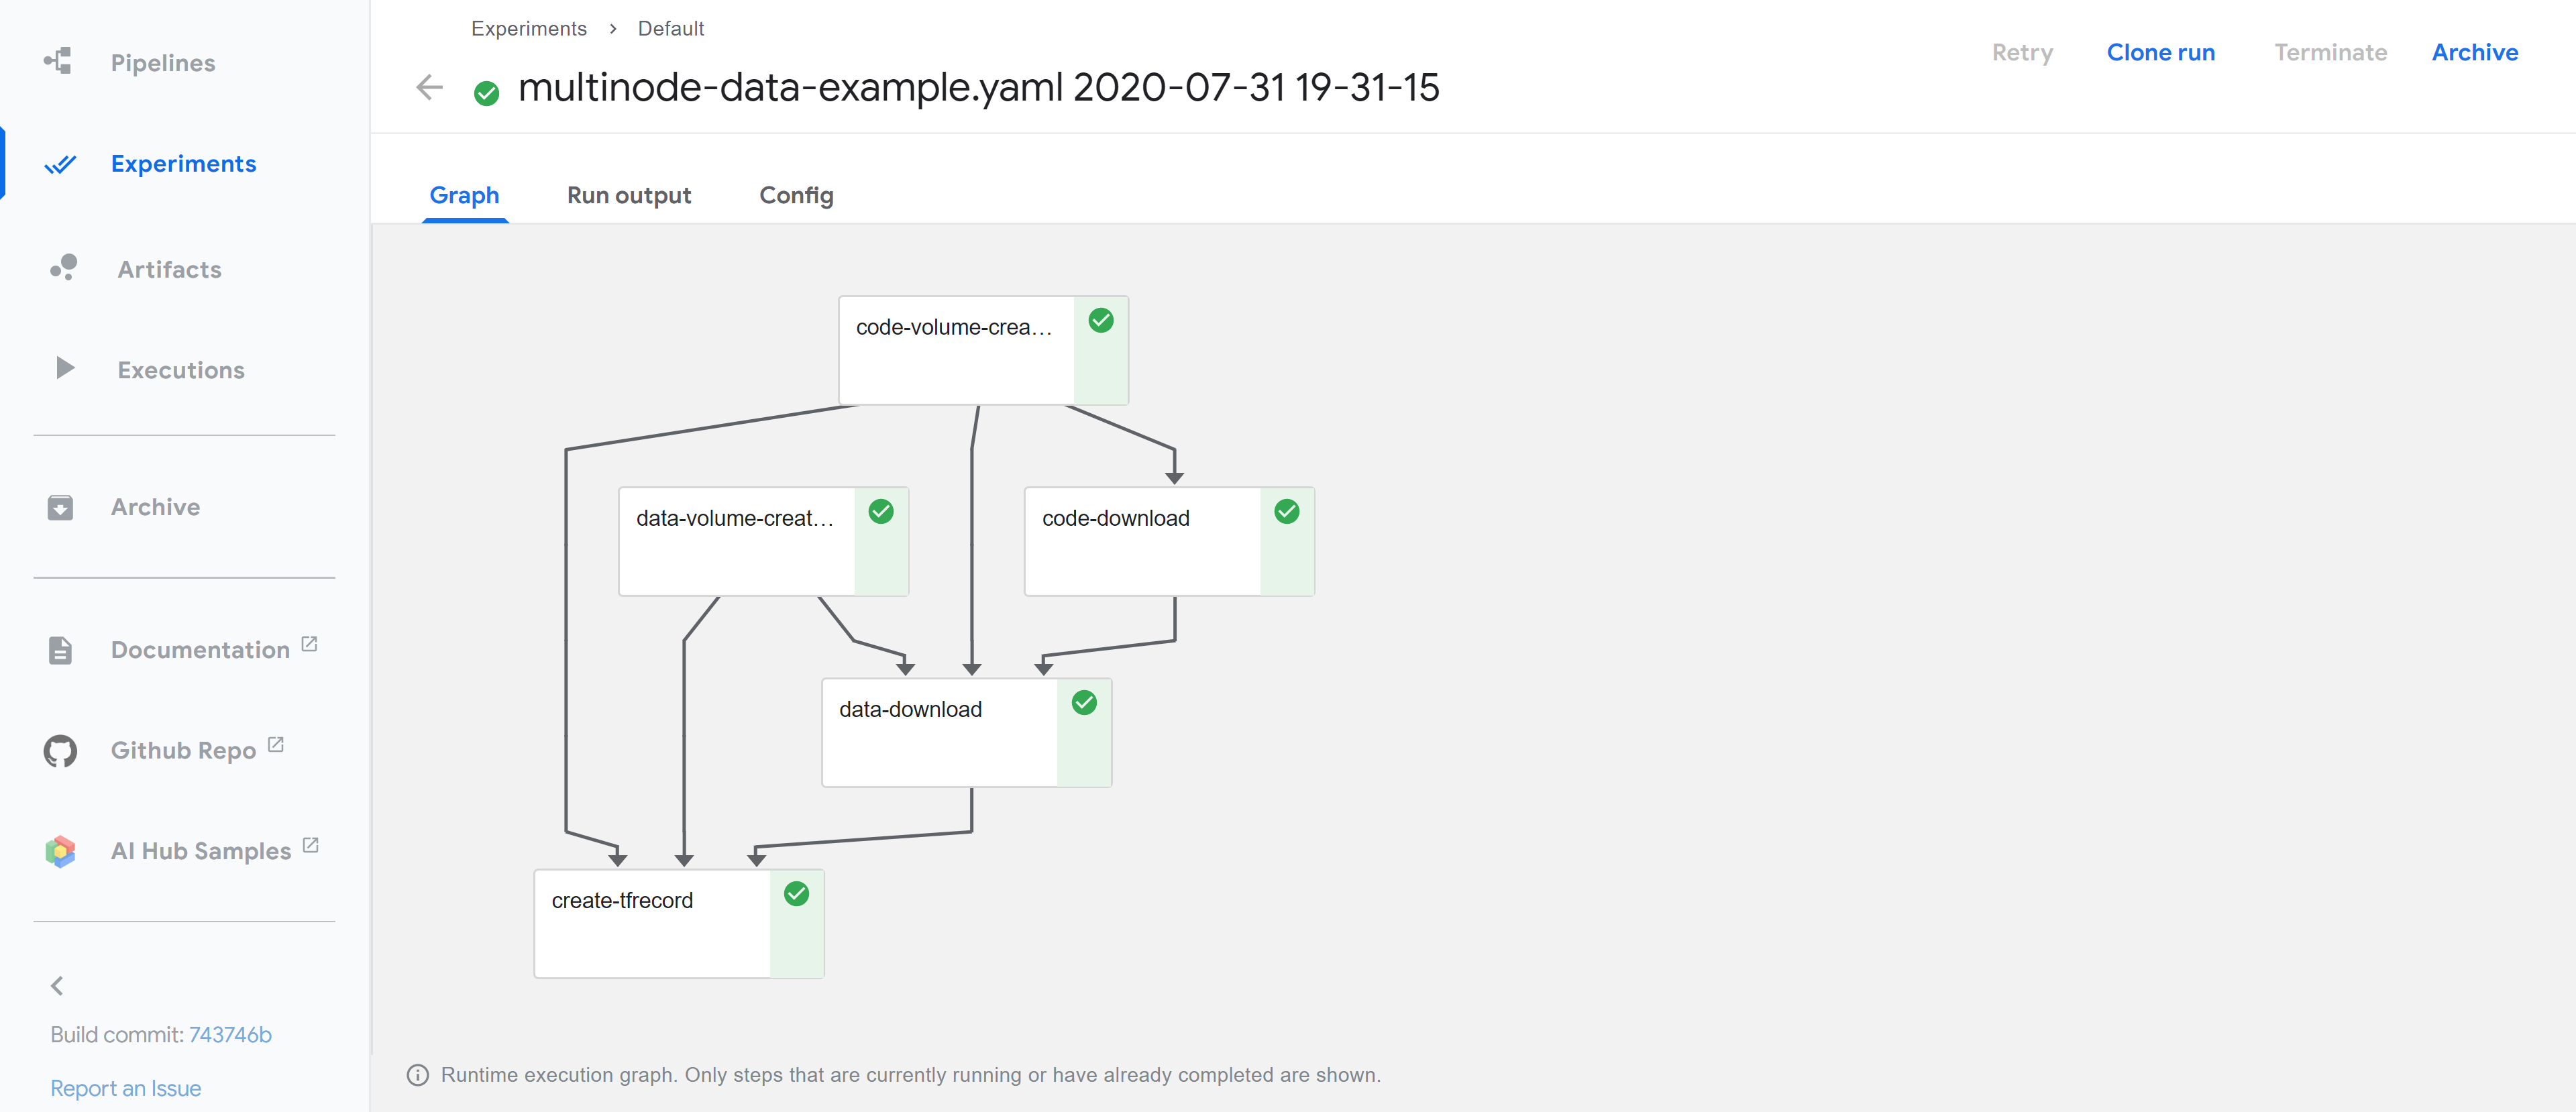

In [8]:
# Wait 1 minute for the initial volumes to be provisioned before grabbing the initial run status
time.sleep(60)

In [9]:
# Poll Kubeflow for the information and current state of the run being executed
run_info = kfp.Client(host=None).get_run(run_result.run_id)

In [10]:
# Save off the names of the Volumes for later use
mpijob_name = json.loads(run_info.pipeline_runtime.workflow_manifest)['metadata']['name']
code_volume = mpijob_name + "-transformer_xl_code"
data_volume = mpijob_name + "-transformer_xl_data"
print(f'Code PersistentVolume: {code_volume}')
print(f'Data PersistentVolume: {data_volume}')

Code PersistentVolume: multinode-data-poc-6xgmb-transformer_xl_code
Data PersistentVolume: multinode-data-poc-6xgmb-transformer_xl_data


In [11]:
# Wait 10 minutes for all data to download and be processed before proceeding to the MPI training job
time.sleep(600) 

### Running an MPIJob pipeline
Because of how MPIJobs are created, we cannot use the Kubeflow `ContainerOps` used in the previos pipeline. We must use a Kubeflow `ResourceOp` that will create an `MPIJob` Kubernetes Resource object. Before creating the `ResourceOp` we must define the YAML for the object using a few kubernetes parameters, MPI specific parameters, and application specific options including:

**Kubernetes**
* We specify for the MPIJob to be created in the namespace `admin`. This could be any namespace and will default to the namespace of the current notebook.
* We set the name of the MPIJob to something random (`"mpi-{}".format(str(uuid.uuid1())[0:8])`), this will allow us to re-run the pipeline without worrying about losing results or collisions.
* We mount the Volumes created during the previous Pipeline so that all the MPI Workers have access to the same pre-downloads, pre-processed dataset.
* Disable the istio sidecar to prevent networking issues (`sidecar.istio.io/inject: false`)

**MPI**
* `slotsPerWorker`: Number of GPUs (`N`)
* `nvidia.com/gpu: 1`: Number of GPUs per Worker (`N`)
* `Worker.replicas`: Number of GPU Workers (`M`)
* `mpirun -np <#>`: Number of GPUs (`N * M`)


**Application**
* `4 # GPU Pods (X)`: This is the number of GPUs (N * M). This application was originally designed to run on a DGX-2, so X * batch_chunk should equal 16. (`X`)
* `--batch_chunk 4`: Batches to run through. Decrease this proportionally to increases in `X`. (`Y`)


This example will launch 4 Pods, each with a single GPU. Depending on the cluster size we could use several different parameter combinations such as:

*1 DGX Station (4 GPUs total): N=1, M=4, X=4
*1 DGX Station (4 GPUs total): N=4, M=1, X=4
*2 DGX-1s (16 GPUs total): N=8, M=2, X=2
*1 DGX-2 (16 GPUs total): N=16, M=1, X=1

> *Note that this example is not guaranteeing best performance. For best performance you will always want to have each Worker Pod to have all GPUs on the node, this ensures that models benefiting from extra bandwidth can take full advantage of GPU interconnect technologies such as [NVLink](https://www.nvidia.com/en-us/data-center/nvlink/) and [NVSwitch](https://www.nvidia.com/en-us/data-center/nvlink/). For example if running with 2 DGX-1s having 2 Workers each with 8 GPUs. In the example abouve the second DGX Station configuration will likely be more performant.

In [17]:
import yaml
import uuid
import kfp
import kfp.dsl as dsl


@dsl.pipeline(
    name="Multinode POC",
    description="A quick hello-world MPIJob resource using the NGC TransformerXL example"
)
def resourceop_multinode():
    # Use the Tensorflow Docker Image from NGC https://ngc.nvidia.com/catalog/containers/nvidia:tensorflow   
    __IMAGE_VERSION__ = 'nvcr.io/nvidia/tensorflow:20.06-tf1-py3'
    
    mpijob_name = "mpi-{}".format(str(uuid.uuid1())[0:8])
    kubeflow_ns = 'kubeflow'
    MPIJOB = f"""apiVersion: kubeflow.org/v1alpha2
kind: MPIJob
metadata:
  name: {mpijob_name}
  namespace: {kubeflow_ns}
spec:
  slotsPerWorker: 1
  cleanPodPolicy: Running
  mpiReplicaSpecs:
    Launcher:
      replicas: 1
      template:
        metadata:
          annotations:
            sidecar.istio.io/inject: "false"
        spec:
          volumes:
          - name: {code_volume}
          - name: {data_volume}
          containers:
          - image: {__IMAGE_VERSION__}
            name: multinode-example
            volumeMounts:
            - mountPath: "/mnt"
              name: {code_volume}
            - mountPath: "/data"
              name: {data_volume}
            command:
            - mpirun
            - -np
            - "4"
            - -bind-to
            - none
            - -map-by
            - slot
            - -x
            - NCCL_DEBUG=INFO
            - -x
            - LD_LIBRARY_PATH
            - -x
            - PATH
            - -mca
            - pml
            - ob1
            - -mca
            - btl
            - ^openib
            - --allow-run-as-root
            - python
            - /mnt/DeepLearningExamples/TensorFlow/LanguageModeling/Transformer-XL/tf/main.py
            - --data_dir
            - /data/tfrecords.apps.train
            - --record_info_dir
            - /data/tfrecords/
            - --corpus_info_path
            - /data/corpus-info.json
            - --div_val
            - "1"
            - --untie_r
            - "True"
            - --proj_share_all_but_first=True
            - --n_layer
            - "16"
            - --d_model
            - "512"
            - --d_embed
            - "512"
            - --n_head
            - "8"
            - --d_head
            - "64"
            - --d_inner
            - "2048"
            - --dropout
            - "0.1"
            - --dropatt
            - "0.0"
            - --learning_rate
            - "0.01"
            - --warmup_steps
            - "1000"
            - --tgt_len
            - "192"
            - --mem_len
            - "192"
            - "4"
            - --amp
            - --batch_chunk
            - "4"
    Worker:
      # The number of workers (M)
      replicas: 1
      template:
        metadata:
          annotations:
            sidecar.istio.io/inject: "false"
        spec:
          volumes:
          - name: {code_volume}
          - name: {data_volume}
          containers:
          - image: {__IMAGE_VERSION__}
            name: multinode-example
            resources:
              limits:
                # The number of GPUs per-worker (N)
                nvidia.com/gpu: 1
            volumeMounts:
            - mountPath: "/mnt"
              name: "{code_volume}"
            - mountPath: "/data"
              name: "{data_volume}" """
 
    # Train TransformerXL model on multiple Kubernetes Pods, this could be on several nodes
    train_op = dsl.ResourceOp(
            name="multinode-example",
            k8s_resource=yaml.load(MPIJOB),
            action='create',
        )

In [18]:
# Compile the pipeline to a local file
kfp.compiler.Compiler().compile(resourceop_multinode, 'multinode-example.yaml')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:117: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


In [19]:
# This will kick off the initial Kubeflow pipeline, the results can be queried/polled using the SDK or through the GUI
run_result = kfp.Client(host=None).create_run_from_pipeline_package('multinode-example.yaml', arguments={})

![mpijob-pipeline.png](mpijob-pipeline.png)

### Polling status and logs for an MPIJob

Because the `MPIJob` is created using a `ResourceOp` the pipeline will "complete" as soon as the MPIJob object is created. However, the MPIJob will spawn a "Launcher" Pod and `M` "Worker" Pods. These pods will continue to run after the Pipeline has completed, it is up to the user to ensure these resources are cleaned up and to collect logging information from these Pods.

After deploying the MPIJob Pipeline, we can get the randomly generated name of the Launcher Pod. This Pod collects the stdout from all Worker Pods and we can tail the logs in the notebook by continuously running the `kubectl logs` command below. We can also tail the logs coninuosly by running a similar `kubectl logs -f` command from a Jupyter terminal.

In [ ]:
%%bash -s "$mpijob_name"
launcher=$(./kubectl get pods --no-headers -o custom-columns=":metadata.name" | grep $1-launcher)
echo "Getting logs for $launcher"
./kubectl logs $launcher multinode-example

### Cleanup
Lastly, when we are done with the MPIJob and have collected the logs or model outputs that we need, we can delete the MPIJob object.

In [ ]:
%%bash -s "$mpijob_name"
echo "Deleting $1"
# ./kubectl delete mpijobs $1